In [1]:
from IPython.display import HTML
from IPython.display import display, Markdown


HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Non-linear resonator dynamics simulation

The purpose of this notebook is to simulate ${\lambda}/{4}$ coplanar waveguide resonators, capacitively coupled to an open transmission line in a notch configuration.

<br>

<div>
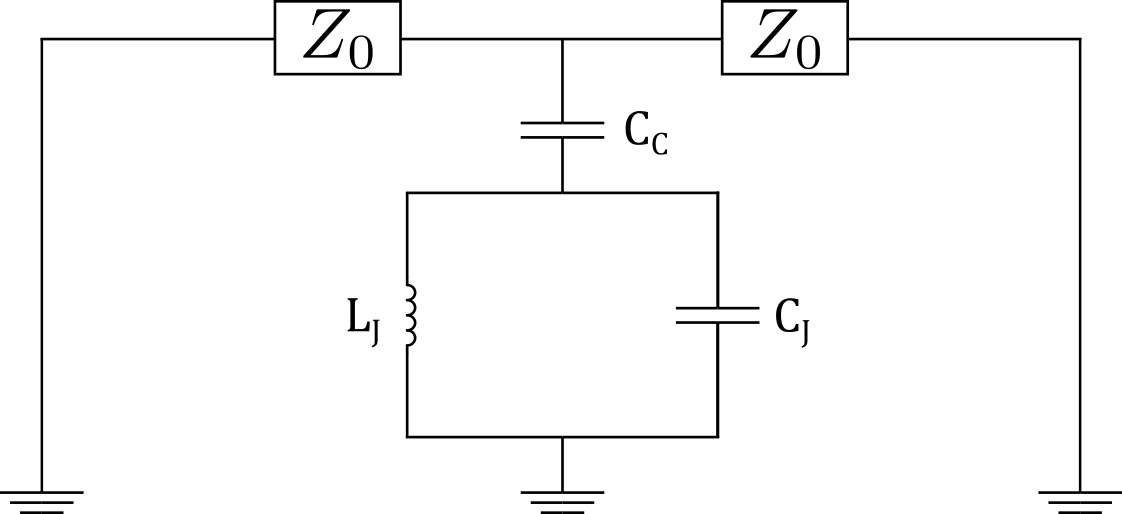
</div>

These resonators are designed and assumed to behave linearly, described as a harmonic LC oscillator to a generally satisfactory degree. 
We explore whether defects and loss channels, such as parasitic TLS, can give rise to non-linearities that are overlooked in ideal models.

<br>

<div>
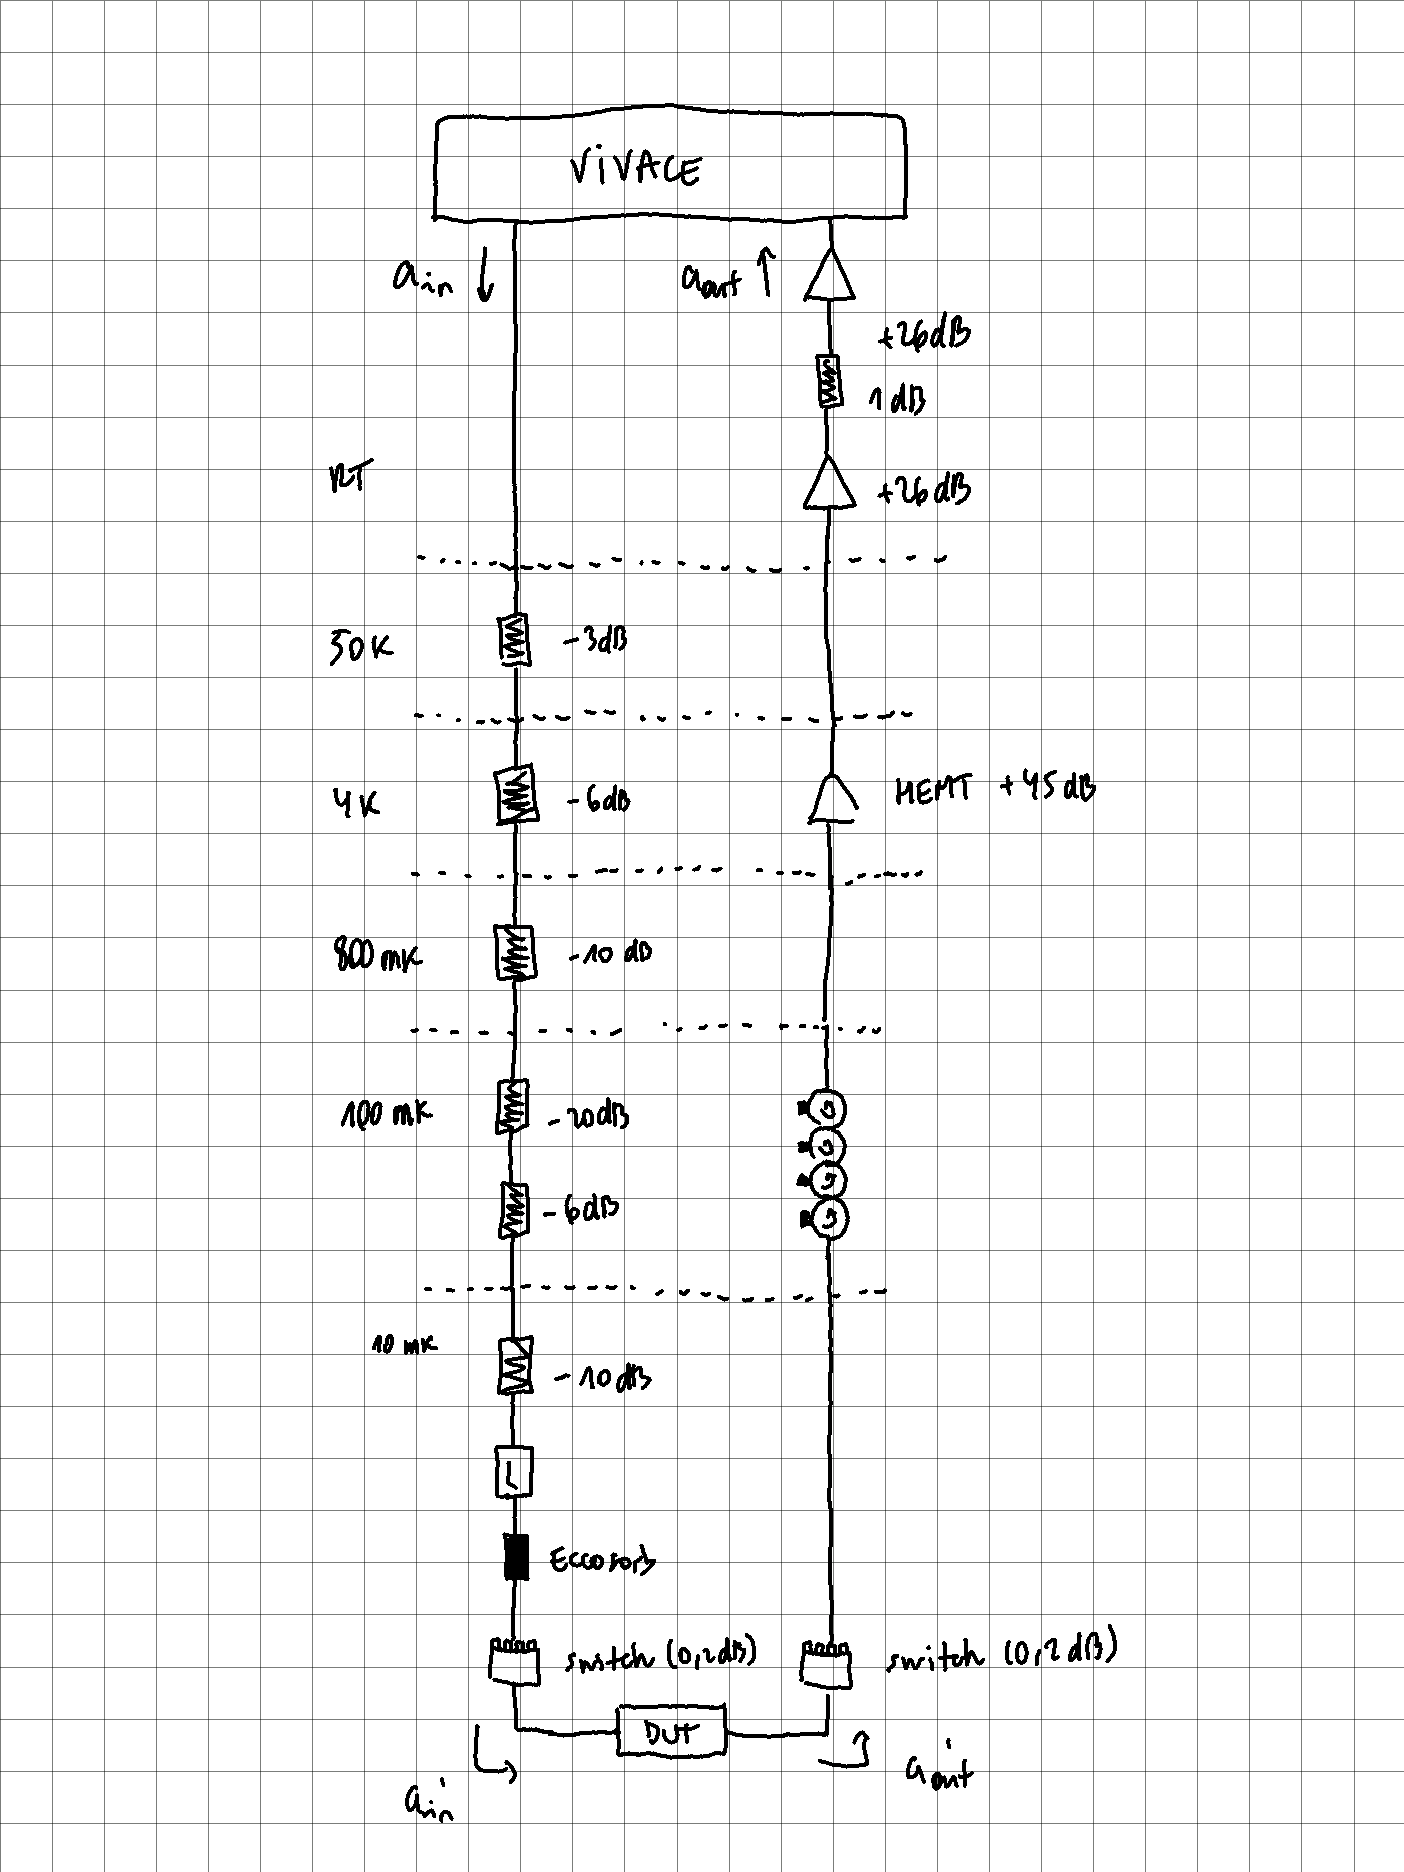
</div>

<br>
Our goal is to simulate the internal dynamics of the resonator $(a)$.
Nevertheless, we only have direct access to information at the input $(a_{in})$ and output $(a_{in})$ of the system.
Therefore, to calculate the intra-cavity field we use input-output theory to obtain

$$ \dfrac{1}{\sqrt{G}} a_{out} = \dfrac{1}{\sqrt{\mathcal{A}}} a_{in} + \lambda a \quad \rightarrow \quad a = \dfrac{1}{\lambda} \left( \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right), $$

where $G$ and $\mathcal{A}$ are the gain and attenuation of the output and input line respectively, and $\lambda$ represents the waveguide-resonator coupling rate.

The dynamics of the resonator are described by the Heisenberg equation of motion 

$$ \dot{a} = -i \omega_r a - \kappa_0 a - \kappa_{TLS}(a) a + \dfrac{\lambda}{\sqrt{\mathcal{A}}}a_{in}, $$

where $\omega_r$ indicates the resonant frequency, $\kappa_0$ the linear dissipation and $\kappa_{TLS}(a)$ the non-linear dissipation due to the TLS of the cavity.

The TLS non-linear dissipation is given by

$$ \kappa_{TLS}(a) = \dfrac{ \kappa_{TLS}}{\sqrt{1+ \left( a/a_c \right)^2}}  $$

Including this expression in the equation of motion we get

$$ \dot{a} = -i \omega_r a - \kappa_0 a - \dfrac{ \kappa_{TLS}}{\sqrt{1+ \left( a/a_c \right)^2}} a + \dfrac{\lambda}{\sqrt{\mathcal{A}}}a_{in}. $$

We now rewrite this expression in terms of the output and input fields as

$$ \dfrac{\dot{a}_{out}}{\sqrt{G}} - \dfrac{\dot{a}_{in}}{\sqrt{\mathcal{A}}} = -i \omega_r \left( \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) - \kappa_0 \left( \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) - \dfrac{ \kappa_{TLS}}{\sqrt{1+ \left[ \left( \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right)/(\lambda a_c) \right]^2}} \left( \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) + \dfrac{\lambda^2}{\sqrt{\mathcal{A}}}a_{in}. $$

We also consider two known drive tones of the form

$$ a_{in} = F_0 \left( \cos({\omega_1}t) + \cos({\omega_2}t) \right) $$

We then solve the differential equation numerically using the following parameters

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.linalg
import ipywidgets as widgets
from functools import partial
from scipy.integrate import ode
from scipy.signal import find_peaks
from ipywidgets import interactive
from tqdm import tqdm
from scipy.optimize import curve_fit

plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['figure.constrained_layout.use'] = True

# Greek alphabet: α, β, γ, δ, ε, ζ, η, θ, ι, κ, λ, μ, ν, ξ, ο, π, ρ, ς, σ, τ, υ, φ, χ, ψ, ω

# Constants
π = np.pi

In [67]:
# Functions
def eom_nonlinear(time, state, fr, kappa0, kappa_tls, ac, lambd, drives, ddrives):
    # resonant frequency
    ωr = 2*π * fr
    
    # state normalized by gain
    state_norm = state / np.sqrt(gain)
    
    # drives and its derivatives normalized by attenuation
    drives_norm = drives(time) / np.sqrt(att)
    ddrives_norm = ddrives(time) / np.sqrt(att)
    
    return  np.sqrt(gain) * (-1.0j*ωr*(state_norm-drives_norm) - kappa0*(state_norm-drives_norm) - kappa_tls/np.sqrt(1+((np.abs(state_norm-drives_norm)/(ac*lambd))**2))*(state_norm-drives_norm) + ddrives_norm + lambd**2*drives_norm)


def eom_nonlinear_real(time, state_real, fr, kappa0, kappa_tls, ac, lambd, drives, ddrives):
    state_complex = state_real[::2] + 1j*state_real[1::2]
    ret_complex = eom_nonlinear(time, state_complex, fr, kappa0, kappa_tls, ac, lambd, drives, ddrives)
    tmp = np.zeros(len(ret_complex)*2)
    tmp[::2] = np.real(ret_complex)
    tmp[1::2] = np.imag(ret_complex)
    
    return tmp


def imp_drive(time, fd1, fd2, B, φ1=0, φ2=0):
    # drive frequencies
    ω1 = 2*π * fd1
    ω2 = 2*π * fd2
    
    return B*(np.cos(ω1*time + φ1) + np.cos(ω2*time + φ2))


def imp_drive_derivative(time, fd1, fd2, B):
    # drive frequencies
    ω1 = 2*π * fd1
    ω2 = 2*π * fd2
    
    return -B*(ω1*np.sin(ω1*time) + ω2*np.sin(ω2*time))


def nonlinear_simulation(fr, kappa0, kappa_tls, ac, lambd, fd1, fd2, B):
    # Drive tones
    drives = partial(imp_drive, fd1=fd1, fd2=fd2, B=B)
    ddrives = partial(imp_drive_derivative, fd1=fd1, fd2=fd2, B=B)
    
    # Integrator
    o = ode(eom_nonlinear_real).set_integrator('lsoda', atol=1e-11, rtol=1e-11)
    o.set_f_params(fr, kappa0, kappa_tls, ac, lambd, drives, ddrives)
    o.set_initial_value(y0, 0)
    
    # Time-domain solution
    y_all = np.zeros((len(t_all), len(y0)))
    for i,t in enumerate(t_all):
        o.integrate(t)
        y_all[i] = o.y
        
    
    # Merge the results onto the complex plane
    field_all = y_all[:,0] + 1.0j*y_all[:,1]
    
    # We save one oscillation once we reached the steady state
    field = field_all[-N-1:-1]
    t = t_all[-N-1:-1]
    
    # Fourier domain solution
    Field = np.fft.fft(field) / len(field)
    freqs = np.fft.fftfreq(len(t), d=dt)


    # Indices of the IMPs
    max_ind_pos = find_peaks(x=np.abs(Field[920:990]),
                             height=1e-10,
                            )
    max_ind_neg = find_peaks(x=np.abs(Field[-990:-920]),
                             height=1e-10,
                            )
    
    max_ind = np.append(max_ind_pos[0]+920, len(Field)-990+max_ind_neg[0])
        
    # Drive indices
    ind_drives = np.array([954, 956, 19044, 19046])
    
    # Generated drive array in the frequency and time domain
    Field_in = np.zeros_like(Field, dtype=complex)
    Field_in[ind_drives] = 0.5
    field_in = np.fft.ifft(Field_in)
    field_in *= len(field_in)
    
    return Field, Field_in, field_all, field, field_in, freqs, t, drives, max_ind


def recon_nonlinear(Field, Field_in, field, field_in, freqs):
    # Angular frequency
    ω = 2*π * freqs
    
    # Create H-matrix
    col1 = (1.0j*ω*(Field/np.sqrt(gain) - Field_in/np.sqrt(att)))
    col2 = 1.0j*(Field/np.sqrt(gain) - Field_in/np.sqrt(att))
    col3 = (Field/np.sqrt(gain) - Field_in/np.sqrt(att))
    col4 = np.fft.fft((field/np.sqrt(gain) - field_in/np.sqrt(att))**3 ) / len(field)
    col5 = np.fft.fft((field/np.sqrt(gain) - field_in/np.sqrt(att))**5 ) / len(field)
    col6 = np.fft.fft((field/np.sqrt(gain) - field_in/np.sqrt(att))**7 ) / len(field)
    col7 = np.fft.fft((field/np.sqrt(gain) - field_in/np.sqrt(att))**9 ) / len(field)
    
    # Merge all columns
    H = np.vstack((col1, col2, col3, col4, col5, col6, col7))
    
    # Making the matrix real instead of complex
    Hcos = np.real(H)
    Hsin = np.imag(H)
    H = np.hstack((Hcos, Hsin))
    
    # Normalize H for a more stable inversion
    Nm = np.diag(1. / np.max(np.abs(H), axis=1))
    H_norm = np.dot(Nm, H)  # normalized H-matrix
    
    # The drive vector, Q (from the Yasuda paper)
    Qcos = np.real(Field_in/np.sqrt(att))
    Qsin = np.imag(Field_in/np.sqrt(att))
    Qmat = np.hstack((Qcos, Qsin))
    
    # Solve system Q = H*p
    H_norm_inv = scipy.linalg.pinv(H_norm)
    p_norm = np.dot(Qmat, H_norm_inv)
    
    # Re-normalize p-values
    # Note: we have actually solved Q = H * Nm * Ninv * p
    # Thus we obtained Ninv*p and multiply by Nm to obtain p
    p = np.dot(Nm, p_norm)  # re-normalize parameter values
    
    # Forward calculation to check result, should be almost everything zero vector
    Q_fit = np.dot(p, H)
    
    # Scale parameters by drive force assuming known resonant frequency
    param_recon = p
    
    # Parameters reconstructed
    lambda_recon = 1 / param_recon[0]
    fr_recon = lambda_recon * param_recon[1] / (2*π)
    kappa1_recon = lambda_recon * param_recon[2]
    kappa3_recon = lambda_recon * param_recon[3]
    kappa5_recon = lambda_recon * param_recon[4]
    kappa7_recon = lambda_recon * param_recon[5]
    kappa9_recon = lambda_recon * param_recon[6]
    
    return lambda_recon, fr_recon, kappa1_recon, kappa3_recon, kappa5_recon, kappa7_recon, kappa9_recon, Q_fit

In [4]:
# Gain and attenuation of the measurement lines
gain = 1
att = 1

# Drive parameters
λ = 1
F0 = 1
f1 = 0.954
f2 = 0.956
df = 0.001
fs = 20
N = int(round(fs/df))

# Integration parameters
T = 1. / df
T_relax = 3 * T
dt = 1. / fs
t_all = dt*(np.arange((T+T_relax)/dt) + 1) 

# Initial conditions
y0 = [0,0]

SIMULATION PARAMETERS
f0 = 0.955 Hz
κ0 = 0.02500
κtls = 0.00025
ac = 0.5
λ = 1
Q_factor = 20


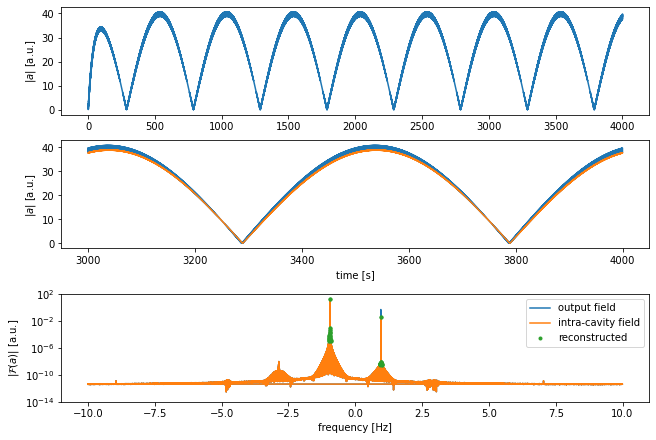

In [5]:
%matplotlib inline
verbose = False

# System parameters
f0 = 0.955
κ0 = 0.025
κtls = κ0/100
ac = 0.5
Q_factor = 1/(2*κ0)

print('SIMULATION PARAMETERS')
print(f'f0 = {f0:.3f} Hz')
print(f'κ0 = {κ0:.5f}')
print(f'κtls = {κtls:.5f}')
print(f'ac = {ac:.1f}')
print(f'λ = {λ:.0f}')
print(f'Q_factor = {Q_factor:.0f}')


# Simulation
A, Ain, a_all, a, ain, f, t_arr, drive, imp_ind = nonlinear_simulation(f0, κ0, κtls, ac, λ, f1, f2, F0)

# Check that the generated drive matches with the simulated drive
if verbose:
    # Drive array in time domain
    ain_all_simu = drive(t_all)
    ain_simu = ain_all_simu[-N-1:-1]
    Ain_simu = np.fft.fft(ain_simu) / len(ain_simu)
    
    # Drives in time and frequency domain
    fig, ax = plt.subplots(3, 1, figsize=[9, 6])
    ax[0].plot(t_all, np.abs(ain_all_simu))
    ax[1].plot(t_arr, np.abs(ain_simu), label='Simulated')
    ax[1].plot(t_arr, np.abs(ain), label='Generated')
    ax[2].semilogy(f, np.abs(Ain_simu), label='Simulated')
    ax[2].semilogy(f, np.abs(Ain), label='Generated')
    ax[0].set_ylabel('$|a_{in}|$ [a.u.]')
    ax[1].set_xlabel('time [s]')
    ax[1].set_ylabel('$|a_{in}|$ [a.u.]')
    ax[2].set_xlabel('frequency [Hz]')
    ax[2].set_ylabel('$|\mathcal{F}(a_{in})|$ [a.u.]')
    ax[0].set_ylim(-0.1, 3)
    ax[2].set_ylim(1e-17, 100)
    ax[2].legend()


# Intra-cavity field in time and frequency domain
fig1, ax1 = plt.subplots(3, 1, figsize=[9, 6])
ax1[0].plot(t_all, np.abs(a_all) )
ax1[1].plot(t_arr, np.abs(a), label='output field')
ax1[1].plot(t_arr, np.abs(a/np.sqrt(gain)-ain/np.sqrt(att)), label='intra-cavity field')
ax1[2].semilogy(f, np.abs(A), label='output field')
ax1[2].semilogy(f, np.abs(A/np.sqrt(gain)-Ain/np.sqrt(att)), label='intra-cavity field')
ax1[2].semilogy(f[imp_ind], np.abs(A/np.sqrt(gain)-Ain/np.sqrt(att))[imp_ind], '.', label='reconstructed')
ax1[0].set_ylabel('$|a|$ [a.u.]')
ax1[1].set_xlabel('time [s]')
ax1[1].set_ylabel('$|a|$ [a.u.]')
ax1[2].set_xlabel('frequency [Hz]')
ax1[2].set_ylabel('$|\mathcal{F}(a)|$ [a.u.]')
ax1[2].set_ylim(1e-14, 100)
ax1[2].legend()

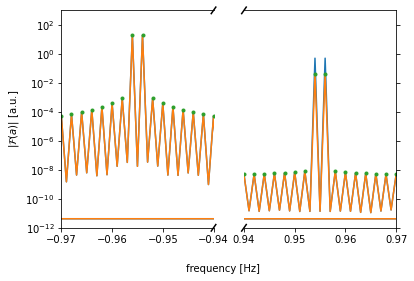

In [6]:
# Plot only the region of interest

# create two subplots
def plot_brokenaxis(x, y, ynorm, xlim1, xlim2):
    figure, axis = plt.subplots(1, 2, sharey=True, constrained_layout=False)

    axis[0].set_ylabel('$|\mathcal{F}(a)|$ [a.u.]')
    figure.suptitle('frequency [Hz]', y=0, fontsize='medium')

    # Plot same data on both axis
    axis[0].semilogy(x, np.abs(y), label='output field')
    axis[1].semilogy(x, np.abs(y), label='output field')
    axis[0].semilogy(x, np.abs(ynorm), label='intra-cavity field')
    axis[1].semilogy(x, np.abs(ynorm), label='intra-cavity field')
    axis[0].semilogy(x[imp_ind], np.abs(ynorm[imp_ind]), '.', label='reconstruction')
    axis[1].semilogy(x[imp_ind], np.abs(ynorm[imp_ind]), '.', label='reconstruction')

    # limit each x-axis to the chosen range
    axis[0].set_xlim(*xlim1)
    axis[1].set_xlim(*xlim2)
    axis[0].set_ylim(1e-12, 1e3)

    # hide spines between both axes
    axis[0].spines['right'].set_visible(False)
    axis[1].spines['left'].set_visible(False)
    axis[1].yaxis.tick_right()
    
    # how big to make the diagonal lines in axes coordinates
    d = .015
    
    # arguments to pass plot, just so we don't keep repeating them
    kwargs = dict(transform=axis[0].transAxes, color='k', clip_on=False)
    axis[0].plot((1-d,1+d), (-d,+d), **kwargs)
    axis[0].plot((1-d,1+d), (1-d,1+d), **kwargs)

    kwargs.update(transform=axis[1].transAxes)  # switch to the bottom axes
    axis[1].plot((-d,+d), (1-d,1+d), **kwargs)
    axis[1].plot((-d,+d), (-d,+d), **kwargs)

    # vary the distance between plots 
    figure.subplots_adjust(wspace=0.2)
    
    plt.show()
    
# Plot zoom of the spectra
xlim_n = np.array([-0.97, -0.94])
xlim_p = np.array([0.94, 0.97])
plot_brokenaxis(f, A, A/np.sqrt(gain)-Ain/np.sqrt(att), xlim_n, xlim_p)


In [49]:
def system(t, x, α, β, γ, δ, xc, ω1, ω2):
    return [x[1], -α*x[1] - β*x[1]/np.sqrt(1+(np.abs(x[0])/xc)**2) - γ*x[0] + δ*(np.cos(ω1*t) + np.cos(ω2*t)) ]

def parameters(α, β, γ, δ, xc, ω1, ω2):
    x = np.arange(-7, 7, 0.1)
    y = np.arange(-7, 7, 0.1)
    x, y = np.meshgrid(x, y)
    V = system(0, [x, y], α, β, γ, δ, xc, ω1, ω2)
    u, v = V

    fig2, ax2 = plt.subplots(1)
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')

    plt.streamplot(x, y, u, v)
    plt.show()


interactive_plot = interactive(parameters, 
                               α=(-2.0, 2.0, 0.05),
                               β=(-2, 2, 0.05),
                               γ=(-2, 2, 0.05),
                               δ=(-2, 2, 0.05),
                               xc=(0.1, 2, 0.05),
                               ω1=(0, 2, 0.05),
                               ω2=(0, 2, 0.05),
                              )
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='α', max=2.0, min=-2.0, step=0.05), FloatSlider(value…

## Parameters dependence

We start by sweeping the linear damping coefficient while $\kappa_{tls}$ and $a_c$ remain constants.


In [21]:
# κ0 sweep values
κ0_arr = np.logspace(-4, 1, 51)

# Spectra arrays
A_κ0 = np.zeros((len(κ0_arr), N), dtype=np.complex)
Ain_κ0 = np.zeros_like(A_κ0)

# κ0 sweep
with tqdm(total=len(κ0_arr), ncols=80) as pbar:

    for κ0_ind, κ0_val in enumerate(κ0_arr):
        # Simulation section
        A_κ0[κ0_ind], Ain_κ0[κ0_ind], a_all, a_arr, ain_arr, f_arr, t_arr, drive_arr, imp_ind_arr = nonlinear_simulation(f0, κ0_val, κtls, ac, λ, f1, f2, F0)
        
        pbar.update(1)

100%|███████████████████████████████████████████| 51/51 [32:21<00:00, 38.07s/it]


In [51]:
def κ0_sweep(kappa_ind):
    # Intra-cavity field in time and frequency domain
    figure, ax = plt.subplots(1, 1, figsize=[9, 6])
    ax.set_title(f'$κ_0$ = {κ0_arr[kappa_ind]:.3f}')
    ax.semilogy(f, np.abs(A_κ0[kappa_ind]), label='output field')
    ax.semilogy(f, np.abs(A_κ0[kappa_ind]/np.sqrt(gain)-Ain_κ0[kappa_ind]/np.sqrt(att)), label='intra-cavity field')
    ax.set_xlabel('frequency [Hz]')
    ax.set_ylabel('$|\mathcal{F}(a)|$ [a.u.]')
    ax.set_ylim(1e-15, 1e3)
    ax.set_xlim(-10, 10)
    ax.legend()
    
# Interactive layout  
widgets.interact(κ0_sweep,
                 kappa_ind=widgets.IntSlider(min=0,
                                             max=len(κ0_arr)-1,
                                             step=1,
                                             description='κ_0',
                                            )
                )

interactive(children=(IntSlider(value=0, description='κ_0', max=50), Output()), _dom_classes=('widget-interact…

<function __main__.κ0_sweep(kappa_ind)>

In [52]:
def κ0_sweep_zoom(kappa_ind):
    # IMPs plot
    xlim_n = np.array([-0.97, -0.94])
    xlim_p = np.array([0.94, 0.97])
    plot_brokenaxis(f, A_κ0[kappa_ind], A_κ0[kappa_ind]/np.sqrt(gain)-Ain_κ0[kappa_ind]/np.sqrt(att), xlim_n, xlim_p)
    
# Interactive layout  
widgets.interact(κ0_sweep_zoom,
                 kappa_ind=widgets.IntSlider(min=0,
                                             max=len(κtls_arr)-1,
                                             step=1,
                                             description='κtls_ind',
                                            )
                )

interactive(children=(IntSlider(value=0, description='κtls_ind', max=50), Output()), _dom_classes=('widget-int…

<function __main__.κ0_sweep_zoom(kappa_ind)>

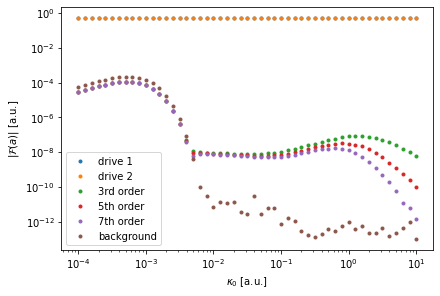

In [26]:
# Plot the 3rd, 5th and 7th IMP strength as a function of drive power
fig3, ax3 = plt.subplots(1)
ax3.loglog(κ0_arr, np.abs(A_κ0[:, 954]), '.', label='drive 1')
ax3.loglog(κ0_arr, np.abs(A_κ0[:, 956]), '.', label='drive 2')
ax3.loglog(κ0_arr, np.abs(A_κ0[:, 956+2]), '.', label='3rd order' )
ax3.loglog(κ0_arr, np.abs(A_κ0[:, 956+4]), '.', label='5th order' )
ax3.loglog(κ0_arr, np.abs(A_κ0[:, 956+6]), '.', label='7th order' )
ax3.loglog(κ0_arr, np.abs(A_κ0[:, -1]), '.', label='background' )
ax3.set_xlabel('$\kappa_{0}$ [a.u.]')
ax3.set_ylabel('$|\mathcal{F}(a)|$ [a.u.]')
ax3.legend()

We then sweep the TLS non-linear damping parameter, while fixing $\kappa_0$ and $a_c$.

In [14]:
# κtls sweep values
κtls_arr = np.logspace(-4, 1, 51)

# Spectra arrays
A_κtls = np.zeros((len(κtls_arr), N), dtype=np.complex)
Ain_κtls = np.zeros_like(A_κtls)

# κtls sweep
with tqdm(total=len(κtls_arr), ncols=80) as pbar:

    for κtls_ind, κtls_val in enumerate(κtls_arr):
        # Simulation section
        A_κtls[κtls_ind], Ain_κtls[κtls_ind], a_all, a_arr, ain_arr, f_arr, t_arr, drive_arr, imp_ind_arr = nonlinear_simulation(f0, κ0, κtls_val, ac, λ, f1, f2, F0)
        
        pbar.update(1)

100%|███████████████████████████████████████████| 51/51 [44:43<00:00, 52.61s/it]


In [53]:
def κtls_sweep(tls_ind):
    # Intra-cavity field in time and frequency domain
    figure, ax = plt.subplots(1, 1, figsize=[9, 6])
    ax.set_title(f'$κtls$ = {κtls_arr[tls_ind]:.4f}')
    ax.semilogy(f, np.abs(A_κtls[tls_ind]), label='output field')
    ax.semilogy(f, np.abs(A_κtls[tls_ind]/np.sqrt(gain)-Ain_κtls[tls_ind]/np.sqrt(att)), label='intra-cavity field')
    ax.set_xlabel('frequency [Hz]')
    ax.set_ylabel('$|\mathcal{F}(a)|$ [a.u.]')
    ax.set_ylim(1e-15, 1e3)
    ax.set_xlim(-10, 10)
    ax.legend()
    
# Interactive layout  
widgets.interact(κtls_sweep,
                 tls_ind=widgets.IntSlider(min=0,
                                           max=len(κtls_arr)-1,
                                           step=1,
                                           description='κtls_ind',
                                          )
                )

interactive(children=(IntSlider(value=0, description='κtls_ind', max=50), Output()), _dom_classes=('widget-int…

<function __main__.κtls_sweep(tls_ind)>

In [20]:
def κtls_sweep_zoom(tls_ind):
    # IMPs plot
    xlim_n = np.array([-0.97, -0.94])
    xlim_p = np.array([0.94, 0.97])
    plot_brokenaxis(f, A_κtls[tls_ind], A_κtls[tls_ind]/np.sqrt(gain)-Ain_κtls[tls_ind]/np.sqrt(att), xlim_n, xlim_p)
    
# Interactive layout  
widgets.interact(κtls_sweep_zoom,
                 tls_ind=widgets.IntSlider(min=0,
                                           max=len(κtls_arr)-1,
                                           step=1,
                                           description='κtls_ind',
                                          )
                )

interactive(children=(IntSlider(value=0, description='κtls_ind', max=50), Output()), _dom_classes=('widget-int…

<function __main__.κtls_sweep_zoom(tls_ind)>

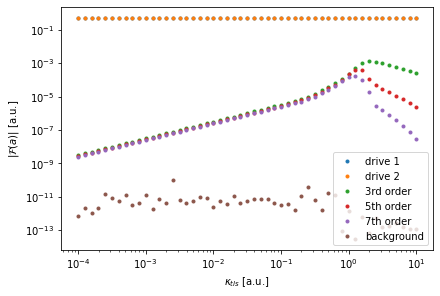

In [18]:
# Plot the 3rd, 5th and 7th IMP strength as a function of drive power
fig4, ax4 = plt.subplots(1)
ax4.loglog(κtls_arr, np.abs(A_κtls[:, 954]), '.', label='drive 1')
ax4.loglog(κtls_arr, np.abs(A_κtls[:, 956]), '.', label='drive 2')
ax4.loglog(κtls_arr, np.abs(A_κtls[:, 956+2]), '.', label='3rd order' )
ax4.loglog(κtls_arr, np.abs(A_κtls[:, 956+4]), '.', label='5th order' )
ax4.loglog(κtls_arr, np.abs(A_κtls[:, 956+6]), '.', label='7th order' )
ax4.loglog(κtls_arr, np.abs(A_κtls[:, -1]), '.', label='background' )
ax4.set_xlabel('$\kappa_{tls}$ [a.u.]')
ax4.set_ylabel('$|\mathcal{F}(a)|$ [a.u.]')
ax4.legend()

Eventually we sweep the $a_c$ parameter.

In [27]:
# ac sweep values
ac_arr = np.logspace(-2, 2, 51)

# Spectra arrays
A_ac = np.zeros((len(ac_arr), N), dtype=np.complex)
Ain_ac = np.zeros_like(A_ac)

# ac sweep
with tqdm(total=len(ac_arr), ncols=80) as pbar:

    for ac_ind, ac_val in enumerate(ac_arr):
        # Simulation section
        A_ac[ac_ind], Ain_ac[ac_ind], a_all, a_arr, ain_arr, f_arr, t_arr, drive_arr, imp_ind_arr = nonlinear_simulation(f0, κ0, κtls, ac_val, λ, f1, f2, F0)
        
        pbar.update(1)

100%|███████████████████████████████████████████| 51/51 [49:26<00:00, 58.16s/it]


In [28]:
def ac_sweep(ac_ind_):
    # Intra-cavity field in time and frequency domain
    figure, ax = plt.subplots(1, 1, figsize=[9, 6])
    ax.set_title(f'$a_c$ = {ac_arr[ac_ind_]:.4f}')
    ax.semilogy(f, np.abs(A_ac[ac_ind_]), label='output field')
    ax.semilogy(f, np.abs(A_ac[ac_ind_]/np.sqrt(gain)-Ain_ac[ac_ind_]/np.sqrt(att)), label='intra-cavity field')
    ax.set_xlabel('frequency [Hz]')
    ax.set_ylabel('$|\mathcal{F}(a)|$ [a.u.]')
    ax.set_ylim(1e-14, 1e4)
    ax.set_xlim(-10, 10)
    ax.legend()
    
# Interactive layout  
widgets.interact(ac_sweep,
                 ac_ind_=widgets.IntSlider(min=0,
                                           max=len(ac_arr)-1,
                                           step=1,
                                           description='ac_ind',
                                          )
                )

interactive(children=(IntSlider(value=0, description='ac_ind', max=50), Output()), _dom_classes=('widget-inter…

<function __main__.ac_sweep(ac_ind_)>

In [29]:
def ac_sweep_zoom(ac_ind_):
    # IMPs plot
    xlim_n = np.array([-0.97, -0.94])
    xlim_p = np.array([0.94, 0.97])
    plot_brokenaxis(f, A_ac[ac_ind_], A_ac[ac_ind_]/np.sqrt(gain)-Ain_ac[ac_ind_]/np.sqrt(att), xlim_n, xlim_p)
    
# Interactive layout  
widgets.interact(ac_sweep_zoom,
                 ac_ind_=widgets.IntSlider(min=0,
                                           max=len(ac_arr)-1,
                                           step=1,
                                           description='ac_ind',
                                          )
                )

interactive(children=(IntSlider(value=0, description='ac_ind', max=50), Output()), _dom_classes=('widget-inter…

<function __main__.ac_sweep_zoom(ac_ind_)>

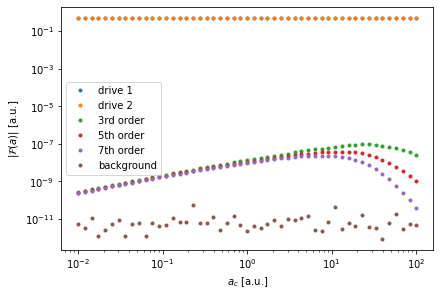

In [32]:
# Plot the 3rd, 5th and 7th IMP strength as a function of drive power
fig5, ax5 = plt.subplots(1)
ax5.loglog(ac_arr, np.abs(A_ac[:, 954]), '.', label='drive 1')
ax5.loglog(ac_arr, np.abs(A_ac[:, 956]), '.', label='drive 2')
ax5.loglog(ac_arr, np.abs(A_ac[:, 956+2]), '.', label='3rd order' )
ax5.loglog(ac_arr, np.abs(A_ac[:, 956+4]), '.', label='5th order' )
ax5.loglog(ac_arr, np.abs(A_ac[:, 956+6]), '.', label='7th order' )
ax5.loglog(ac_arr, np.abs(A_ac[:, -1]), '.', label='background' )
ax5.set_xlabel('$a_c$ [a.u.]')
ax5.set_ylabel('$|\mathcal{F}(a)|$ [a.u.]')
ax5.legend()

## Power dependence

We analyze the power dependence of the IMPs as a function of the drive power.
For that we sweep the parameter $F_0$.


In [7]:
# Power Sweep
F0_arr = np.logspace(0, 2, 101)

# Spectra arrays
A_arr = np.zeros((len(F0_arr), N), dtype=np.complex)
Ain_arr = np.zeros_like(A_arr)

# Power sweep
with tqdm(total=len(F0_arr), ncols=80) as pbar:

    for F0_ind, F0_val in enumerate(F0_arr):
        # Simulation section
        A_arr[F0_ind], Ain_arr[F0_ind], a_all, a_arr, ain_arr, f_arr, t_arr, drive_arr, imp_ind_arr = nonlinear_simulation(f0, κ0, κtls, ac, λ, f1, f2, F0_val)
        
        pbar.update(1)


100%|███████████████████████████████████████| 101/101 [1:13:02<00:00, 43.39s/it]


In [8]:
def amp_sweep(amp_ind):
    # Intra-cavity field in time and frequency domain
    figure, ax = plt.subplots(1, 1, figsize=[9, 6])
    ax.set_title(f'$F_0$ = {F0_arr[amp_ind]:.3f}')
    ax.semilogy(f, np.abs(A_arr[amp_ind]), label='output field')
    ax.semilogy(f, np.abs(A_arr[amp_ind]/np.sqrt(gain)-Ain_arr[amp_ind]/np.sqrt(att)), label='intra-cavity field')
    ax.set_xlabel('frequency [Hz]')
    ax.set_ylabel('$|\mathcal{F}(a)|$ [a.u.]')
    ax.set_ylim(1e-14, 1e4)
    ax.set_xlim(-5, 5)
    ax.legend()
    
# Interactive layout  
widgets.interact(amp_sweep,
                 amp_ind=widgets.IntSlider(min=0,
                                           max=len(F0_arr)-1,
                                           step=1,
                                           description='F0_ind',
                                          )
                )

interactive(children=(IntSlider(value=0, description='F0_ind'), Output()), _dom_classes=('widget-interact',))

<function __main__.amp_sweep(amp_ind)>

In [9]:
def amp_sweep(amp_ind):
    # IMPs plot
    xlim_n = np.array([-0.97, -0.94])
    xlim_p = np.array([0.94, 0.97])
    plot_brokenaxis(f, A_arr[amp_ind], A_arr[amp_ind]/np.sqrt(gain)-Ain_arr[amp_ind]/np.sqrt(att), xlim_n, xlim_p)
    
# Interactive layout  
widgets.interact(amp_sweep,
                 amp_ind=widgets.IntSlider(min=0,
                                           max=len(F0_arr)-1,
                                           step=1,
                                           description='F0_ind',
                                          )
                )

interactive(children=(IntSlider(value=0, description='F0_ind'), Output()), _dom_classes=('widget-interact',))

<function __main__.amp_sweep(amp_ind)>

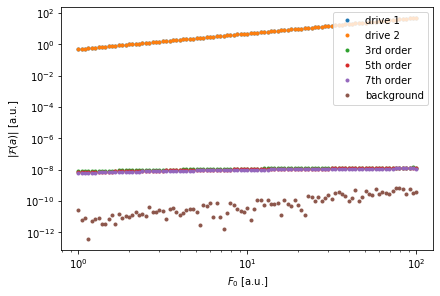

In [10]:
# Plot the 3rd, 5th and 7th IMP strength as a function of drive power
fig6, ax6 = plt.subplots(1)
ax6.loglog(F0_arr, np.abs(A_arr[:, 954]), '.', label='drive 1')
ax6.loglog(F0_arr, np.abs(A_arr[:, 956]), '.', label='drive 2')
ax6.loglog(F0_arr, np.abs(A_arr[:, 956+2]), '.', label='3rd order' )
ax6.loglog(F0_arr, np.abs(A_arr[:, 956+4]), '.', label='5th order' )
ax6.loglog(F0_arr, np.abs(A_arr[:, 956+6]), '.', label='7th order' )
ax6.loglog(F0_arr, np.abs(A_arr[:, -1]), '.', label='background' )
ax6.set_xlabel('$F_0$ [a.u.]')
ax6.set_ylabel('$|\mathcal{F}(a)|$ [a.u.]')
ax6.legend()

## Harmonic balance reconstruction

We now want to reconstruct the simulated system using harmonic balance. 
We first expand the square root of the TLS non-linear damping term as

$$ \kappa_{TLS}(a) = \dfrac{ \kappa_{TLS}}{\sqrt{1+ \left( a/a_c \right)^2}} = \kappa_{TLS} \left( 1 - \dfrac{1}{2} \left( \dfrac{a}{a_c} \right)^2 + \dfrac{3}{8} \left( \dfrac{a}{a_c} \right)^4 + \mathcal{O}(a^6) \right)  $$

Thus the equation of motion up to $4^{th}$ order is given by

$$ \dfrac{\dot{a}_{out}}{\sqrt{G}} - \dfrac{\dot{a}_{in}}{\sqrt{\mathcal{A}}} = -i \omega_r \left( \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) - (\kappa_0+\kappa_{TLS}) \left( \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) + \dfrac{\kappa_{TLS}}{2 \lambda^2 a_c^2} \left( \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right)^3 - \dfrac{3 \kappa_{TLS}}{8 \lambda^4 a_c^4} \left( \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right)^5 + \dfrac{\lambda^2}{\sqrt{\mathcal{A}}}a_{in}. $$

For simplicity we express the previous equation as

$$ \dfrac{\dot{a}_{out}}{\sqrt{G}} - \dfrac{\dot{a}_{in}}{\sqrt{\mathcal{A}}} = -i \omega_r \left( \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) - \kappa_1 \left( \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) - \kappa_3 \left( \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right)^3 - \kappa_5 \left( \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right)^5 + \dfrac{\lambda^2}{\sqrt{\mathcal{A}}}a_{in}. $$

We translate this expression into the Fourier domain, leading to

$$ i \omega_k \left( \dfrac{\dot{A}_{out,k}}{\sqrt{G}} - \dfrac{\dot{A}_{in,k}}{\sqrt{\mathcal{A}}} \right) + i \omega_r \left( \dfrac{A_{out,k}}{\sqrt{G}} - \dfrac{A_{in,k}}{\sqrt{\mathcal{A}}} \right) + \kappa_1 \left( \dfrac{A_{out,k}}{\sqrt{G}} - \dfrac{A_{in,k}}{\sqrt{\mathcal{A}}} \right) + \kappa_3 \mathscr{F}\left\{ \left( \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right)^3 \right\}_k + \kappa_5 \mathscr{F}\left\{ \left( \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right)^5 \right\}_k = \dfrac{\lambda^2}{\sqrt{\mathcal{A}}}A_{in,k}. $$

In matrix form we have

$$ \underbrace{\begin{pmatrix} i \omega_k \left( \dfrac{\dot{A}_{out,k}}{\sqrt{G}} - \dfrac{\dot{A}_{in,k}}{\sqrt{\mathcal{A}}} \right) & i \left( \dfrac{A_{out,k}}{\sqrt{G}} - \dfrac{A_{in,k}}{\sqrt{\mathcal{A}}} \right) & \dfrac{A_{out,k}}{\sqrt{G}} - \dfrac{A_{in,k}}{\sqrt{\mathcal{A}}} & \mathscr{F}\left\{ \left( \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right)^3 \right\}_k & \mathscr{F}\left\{ \left( \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right)^5 \right\}_k \end{pmatrix}}_{\bar{\bar{H}}}  \underbrace{\begin{pmatrix} 1/\lambda^2 \\ \omega_r/\lambda^2 \\ \kappa_1/\lambda^2 \\ \kappa_3/\lambda^2 \\ \kappa_5/\lambda^2 \end{pmatrix}}_{\bar{p}} = \underbrace{\dfrac{A_{in,k}}{\sqrt{\mathcal{A}}}}_{\bar{q}}. $$

In this way we divide the problem into a matrix $\bar{\bar{H}}$ containing the measurement information, a vector $\bar{p}$ with all the unknown parameters and another vector $\bar{q}$ containing the driving terms. To obtain a least squares best fit to the unknown parameters of the system, we use the pseudo-inverse of matrix $\bar{\bar{H}}$ such that 
$$ \bar{p} = \bar{\bar{H}}^+ \bar{q}. $$

In [70]:
# Reconstruction section
λ_recon, f0_recon, κ1_recon, κ3_recon, κ5_recon, κ7_recon, κ9_recon, Qmat_fit = recon_nonlinear(A[imp_ind], Ain[imp_ind], a[imp_ind], ain[imp_ind], f[imp_ind])
λ_recon = np.sqrt(λ_recon)
Q_recon = 1 / (2*κ1_recon)

κ0_recon = κ1_recon - 3*κ3_recon**2/(2*κ5_recon)
κtls_recon = 3*κ3_recon**2/(2*κ5_recon)
ac_recon = 1/λ_recon*np.sqrt(-3*κ3_recon/(4*κ5_recon))

print(f'f0_recon = {f0_recon:.5f} Hz')
print(f'κ0_recon = {κ0_recon}')
print(f'κtls_recon = {κtls_recon}')
print(f'ac_recon = {ac_recon}')
print(f'λ_recon = {λ_recon:.5f}')
print(f'Q_recon = {Q_recon:.2f}')
print('----------------------------------')
print(f'κ1_recon = {κ1_recon}')
print(f'κ3_recon = {κ3_recon}')
print(f'κ5_recon = {κ5_recon}')
print(f'κ7_recon = {κ7_recon}')
print(f'κ9_recon = {κ9_recon}')

f0_recon = 0.95500 Hz
κ0_recon = 0.025004143097017213
κtls_recon = -4.406676717801517e-08
ac_recon = 32.68056564026539
λ_recon = 1.00000
Q_recon = 20.00
----------------------------------
κ1_recon = 0.025004099030250033
κ3_recon = 2.0630136242518775e-11
κ5_recon = -1.4487193478441243e-14
κ7_recon = -1.6422808965049309e-18
κ9_recon = 1.0786255295206297e-21


array([ 2.39802509e-04, -2.61897329e-04,  1.75733415e-04, -5.28082523e-05,
        5.65221480e-06])

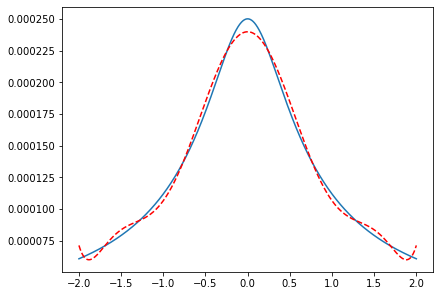

In [72]:
def fit_function(x, a, b, c, d, e):
    return a + b*x**2 + c*x**4 + d*x**6 + e*x**8

x_sim = np.linspace(-2, 2, 1000)
y_sim = κtls/np.sqrt(1 + (x_sim/ac)**2)
# y_recon = κtls_recon*(1 - x_sim**2/(2*ac_recon**2) + 3/8*(x_sim/ac_recon)**4)
popt, pcov = curve_fit(fit_function, x_sim, y_sim)


fig7, ax7 = plt.subplots(1)
ax7.plot(x_sim, y_sim)
ax7.plot(x_sim, fit_function(x_sim, *popt), 'r--')

popt